In [7]:
import main
import detection
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import math

# Load Images

image array:
 [[197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 ...
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]]
num images loaded: 10


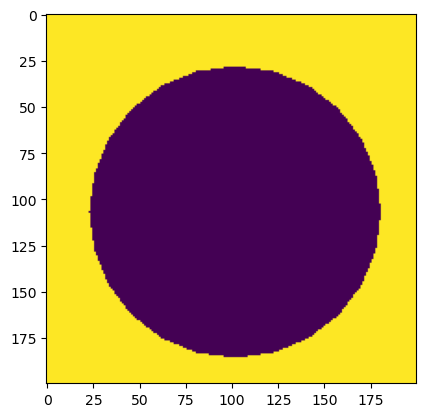

In [8]:
base_path = os.getcwd()

img_path = os.path.join(base_path, "data", "geometric shapes dataset", "Circle", "Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png")

# cv2.imread does not work on linux, im using matlab for visualization
img_BGR = main.load_img(img_path, greyscale=False)
img = main.load_img(img_path)
print("image array:\n", img)
main.plt.imshow(img)

folder_path = os.path.join(base_path, 'data', 'geometric shapes dataset', 'Square')
data = main.load_img_from_folder(folder_path)
print("num images loaded:", len(data))


image shape: (200, 200)
lines detected:
[]


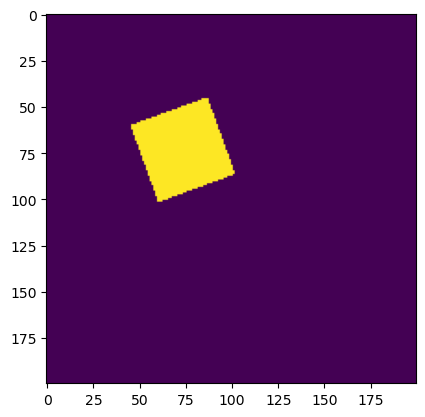

In [10]:
img = data[0]
print("image shape:", img.shape)
main.plt.imshow(img)
lines = detection.detect_line(img, canny_thres1=10, 
             canny_thres2=150, 
             rho=1, 
             theta=main.np.pi/180, 
             hough_thres=80, 
             min_line_len=30, 
             max_line_gap=10)
print("lines detected:")
print(lines)

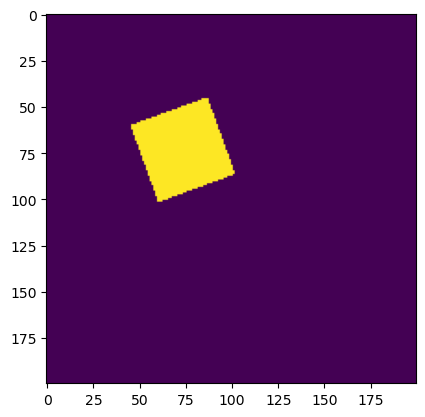

In [11]:
out = detection.draw_lines(img, lines)
main.plt.imshow(out)

# Test Edge Detection on Shapes

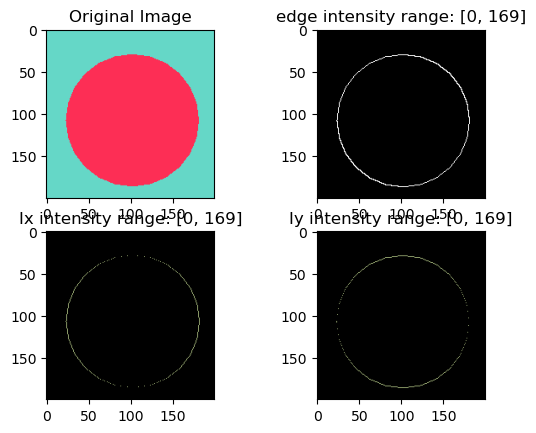

In [12]:
edges, Ix, Iy = detection.detect_edges(img_BGR, derv_len=1, use_sobel=False)

def show_edge_results(img, edges, Ix, Iy):

    def get_minmax(img):
        min = np.min(img)
        max = np.max(img)
        return min, max

    fig, ax = main.plt.subplots(2,2)
    ax[0,0].title.set_text("Original Image")
    ax[0,0].imshow(img)

    min, max = get_minmax(edges)
    ax[0,1].title.set_text(f"edge intensity range: [{min}, {max}]")
    ax[0,1].imshow(edges, cmap='gray', vmin=min, vmax=max)

    min, max = get_minmax(Ix)
    ax[1,0].title.set_text(f"Ix intensity range: [{min}, {max}]")
    ax[1,0].imshow(Ix, vmin=min, vmax=max)

    min, max = get_minmax(Iy)
    ax[1,1].title.set_text(f"Iy intensity range: [{min}, {max}]")
    ax[1,1].imshow(Iy, vmin=min, vmax=max)

show_edge_results(img_BGR, edges, Ix, Iy)

# Test Edge Detection on Physical Parts

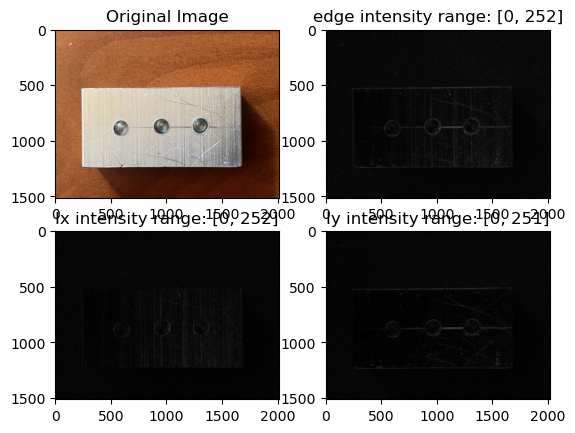

In [13]:
img_path = os.path.join(base_path, "data", "physical parts", "Basic II base part.jpg")

img_part1 = main.load_img(img_path, greyscale=False)
# crop img
H,W = img_part1.shape[0:2]
Z = 4   # zoom factor
Zh = Z//2
img_part1 = img_part1[H*(Zh-1)//Z : H*(Zh+1)//Z , W*(Zh-1)//Z : W*(Zh+1)//Z]
# convert to RGB
img_part1 = main.cv2.cvtColor(img_part1, main.cv2.COLOR_BGR2RGB)

edges, Ix, Iy = detection.detect_edges(img_part1, derv_len=1, use_sobel=False)

show_edge_results(img_part1, edges, Ix, Iy)

# Test edge detection with denoising

Main Idea:
1. Take simple gradient of original image to get *fine edges*, which will have noisy details

2. Blur original image and take gradient of blurred image to get *rough edges*, which will inflate obvious edges and filter out noisy details

3. Use the *rough edges* as a mask to extract wanted details from *fine edges* to get *masked fine edges*, which should contain only details near wanted edges

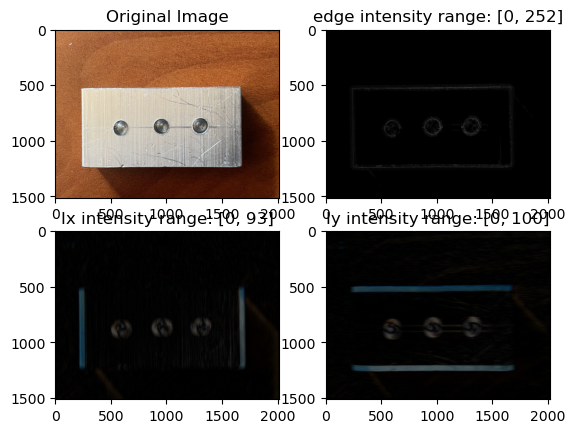

In [14]:
def getEdgesMasked(img):
    # get fine edges (org image, 1-step gradient)
    edges_fine, Ix, Iy = detection.detect_edges(img, derv_len=1)
    # show_edge_results(img, edges_fine, Ix, Iy)

    # gauss blur img
    sigma = 50
    img_part1_gb = cv2.GaussianBlur(img, ksize=(sigma+1,sigma+1), sigmaX=sigma, sigmaY=sigma)
    # take large-step gradient
    step = sigma//10
    step = step if step>0 else 1
    edges_crude, Ix, Iy = detection.detect_edges(img_part1_gb, derv_len=sigma//10)
    # threshold
    thrs = 90   # percentile above which to keep
    edges_crude = np.where(edges_crude>=np.percentile(edges_crude, thrs), 1, 0)
    # show_edge_results(img_part1_gb, edges_crude, Ix, Iy)
    # mask
    edges_masked = np.where(edges_crude>0, edges_fine, 0)

    return edges_masked, Ix, Iy

edges_masked, Ix, Iy = getEdgesMasked(img_part1)

show_edge_results(img_part1, edges_masked, Ix, Iy)


# Run Hough Transform

TODO: Canny may not be necessary with our own edge detector

### A1: original -> Canny -> edges

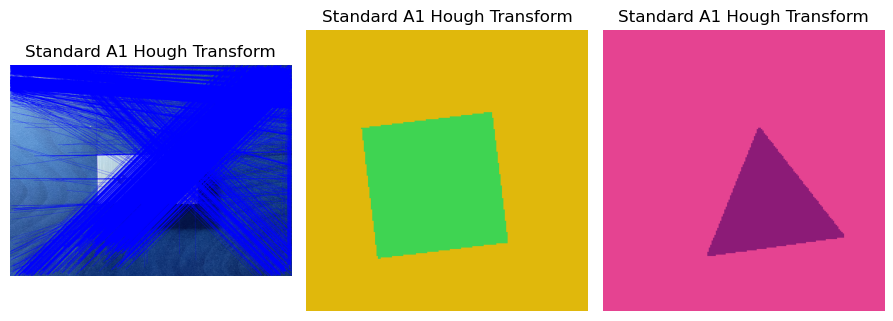

In [15]:

detection.subsample_technique(detection.DETECTION.LINE, "Standard A1 Hough Transform", lambda img: detection.applyHoughTransform(img))

### A2: original -> Blur -> grad -> Threshold -> Canny -> edges

### A3: 
original -> grad ------------------> mask -> edges  
original -> blur -> grad -> thrs ->

In [11]:
# houghOutput = applyHoughTransform(edges_masked)
# showImage(houghOutput)

In [17]:
# APPROACH 3: first: org + FT + FLP -> LPF edges; then: LPF edge + Canny + HT
detection.subsample_technique(detection.DETECTION.LINE, "A3 Hough Transform", lambda img: detection.find_lines(getEdgesMasked(img)[0]))


AttributeError: module 'main' has no attribute 'draw_lines'

<Figure size 1200x1000 with 0 Axes>

### A4:
original -> grad ------------------> mask -> Canny -> edges  
original -> blur -> grad -> thrs ->


found 0 lines
found 0 lines


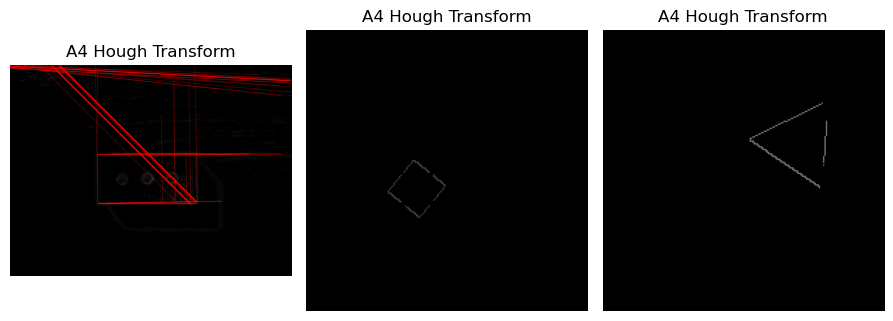

In [ ]:
detection.subsample_technique(detection.DETECTION.LINE, "A4 Hough Transform", lambda img: detection.find_lines(getEdgesMasked(img)[0], canny=True))

### General Insights in using HoughLinesP:
* Set maxLineGap to a large number to pick up long & continuous single lines
* Increase threshold to filter out short noisy lines
* Try not to set minLineLength too high, or actual features that are a bit short might be falsely ignored

### A5: original -> grad -> Canny -> edges

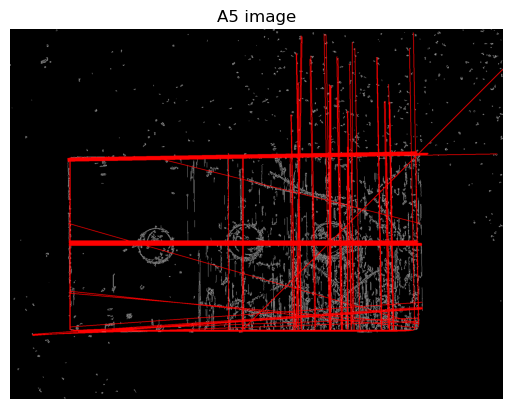

In [15]:
grad, _, _ = detection.detect_edges(img_part1)
# showImage(grad)
edges = cv2.Canny(grad, 50, 150)
# showImage(edges)

found_lines_A5 = detection.find_lines(edges)
detection.display_single_image(found_lines_A5, "A5 image")

In [19]:


detection.subsample_technique(detection.DETECTION.CIRCLE, "Find Circles", lambda img: detection.find_circles(img, blur=True, thresh=40), 0)


error: OpenCV(4.12.0) /Users/runner/miniforge3/conda-bld/libopencv_1760191556309/work/modules/imgproc/src/hough.cpp:2284: error: (-215:Assertion failed) !_image.empty() && _image.type() == CV_8UC1 && (_image.isMat() || _image.isUMat()) in function 'HoughCircles'


<Figure size 1200x1000 with 0 Axes>

found 8 circles


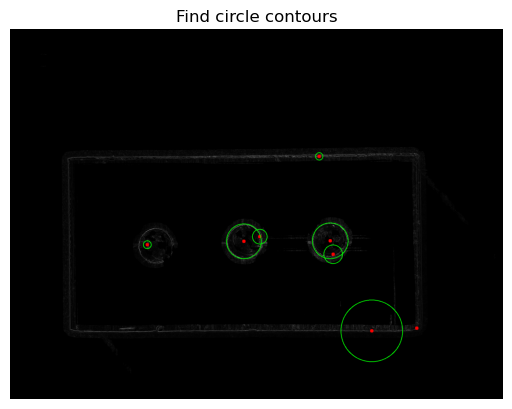

In [66]:
found_circles_CT = find_circles_contours(input, filter=60)
showImage(found_circles_CT, ttl="Find circle contours")

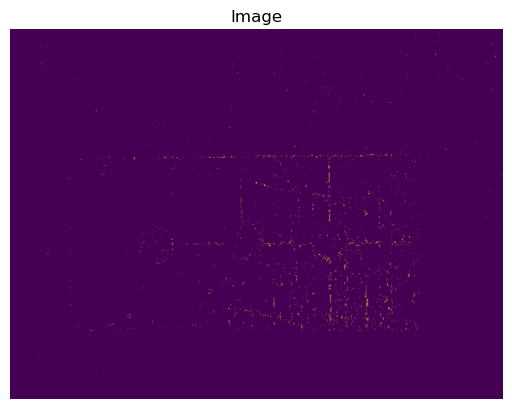

found 4 circles


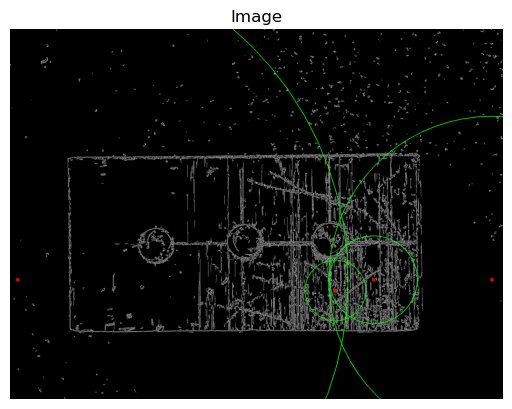

In [67]:
grad, _, _ = main.detect_edges(img_part1)
# showImage(grad)
edges = cv2.Canny(grad, 50, 150)
# showImage(edges)

foundCircles = find_circles(edges, blur=True, thresh=70, dp=1.1)
showImage(foundCircles)

found 301 circles


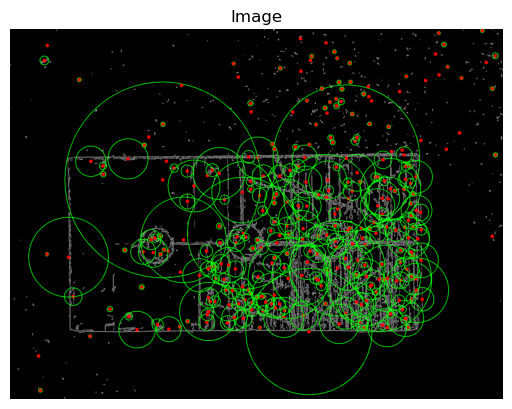

In [68]:
grad, _, _ = main.detect_edges(img_part1)
# showImage(grad)
edges = cv2.Canny(grad, 50, 150)
# showImage(edges)

found_circles_CT = find_circles_contours(edges, filter=60)
showImage(found_circles_CT)

# Ransac Circle Detection

In [1]:
from skimage.measure import ransac, CircleModel

def find_circle_ransac(input_gray):
    # 1) Edge points
    edges = cv2.Canny(input_gray, 80, 200)
    ys, xs = np.nonzero(edges)               # row, col
    points = np.column_stack([xs, ys])       # (x, y) for CircleModel

    if len(points) < 3:
        print("not enough edge points")
        return None, input_gray

    # 2) RANSAC circle fit
    model, inliers = ransac(
        points,
        CircleModel,
        min_samples=3,
        residual_threshold=2.0,   # max distance from circle to be inlier (px)
        max_trials=1000
    )

    xc, yc, r = model.params      # center x, center y, radius
    print(f"center=({xc:.1f},{yc:.1f}), r={r:.1f}, inliers={inliers.sum()}")

    # 3) Draw result
    base = cv2.cvtColor(input_gray, cv2.COLOR_GRAY2BGR)
    cv2.circle(base, (int(xc), int(yc)), int(r), (0, 255, 0), 2)
    cv2.circle(base, (int(xc), int(yc)), 2, (0, 0, 255), 3)

    return (xc, yc, r), cv2.cvtColor(base, cv2.COLOR_BGR2RGB)

In [ ]:
circle_params, img_with_circle = find_circle_ransac(input)
showImage(img_with_circle, ttl="RANSAC circle")
